# Individual Analysis for the Zeeman Effect

In [1]:
import numpy as np
import scipy.constants as const
import uncertainties as unc
import uncertainties.unumpy as up
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline

In [2]:
Mirror_sep = pd.read_csv('FP_mirror_positions.csv') 

d_array = Mirror_sep['Right (cm)'] - Mirror_sep['Left (cm)']

d = np.mean(d_array)
sigma_d = np.std(d_array)

ud = unc.ufloat(d,sigma_d)
ud = ud * const.centi

uFSR = (const.c) / (2*ud)

print('Mirror separation: {:.2uP} mm'.format(ud/const.milli))
print('Free spectral Range: {:.2uP} GHz'.format(uFSR/const.giga))

Mirror separation: 1.7203±0.0025 mm
Free spectral Range: 87.13±0.13 GHz


In [3]:
coeffs = np.array([-9.4193, 33.446, 375.66, 42.845]) # values given in millitesla

B_coeff = coeffs * const.milli
B = np.poly1d(B_coeff)

In [4]:
I_green =  3.612 # current in green line measurement, Amps
sigma_I_green = 0.005 # Amps

unc_I_green = unc.ufloat(I_green,sigma_I_green)

B_green = B(unc_I_green)

print('Field strength at {:.1uP} A = {:.2uP} mT'.format(unc_I_green,B_green/const.milli))

Field strength at 3.612±0.005 A = 1392.2±1.2 mT


In [5]:
yellow_data = pd.read_csv('Yellow_B0.csv',skiprows = 15)

I_yellow = 1.817
sigma_I_yellow = 0.005 

unc_I_yellow = unc.ufloat(I_yellow,sigma_I_yellow)

B_yellow = B(unc_I_yellow)

print('Field strength at {:.1uP} A = {:.2uP} mT'.format(unc_I_yellow,B_yellow/const.milli))

Field strength at 1.817±0.005 A = 779.3±2.0 mT


In [6]:
mu_B = const.value(u'Bohr magneton in Hz/T')
print('mu_B = {:.6g} Hz/T'.format(const.value(u'Bohr magneton in Hz/T')))

mu_B = 1.39962e+10 Hz/T


In [7]:
conv_fact_green = uFSR/(mu_B*B_green)
print('Conversion factor for green lines (Free spectral range in units of B*mu_B): {:.1uP}'.format(conv_fact_green))

conv_fact_yellow = uFSR/(mu_B*B_yellow)
print('Conversion factor for yellow lines (Free spectral range in units of B*mu_B): {:.1uP}'.format(conv_fact_yellow))

Conversion factor for green lines (Free spectral range in units of B*mu_B): 4.472±0.008
Conversion factor for yellow lines (Free spectral range in units of B*mu_B): 7.99±0.02


In [8]:
Green_B0 = pd.read_csv('Green_B0.csv',skiprows = 15) 
Green_3612 = pd.read_csv('Green_3612A_no_polarizer.csv',skiprows = 15)

In [9]:
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 12 cm wde by 8 cm high
mpl.rcParams['font.size'] = 12.0 #12 point font

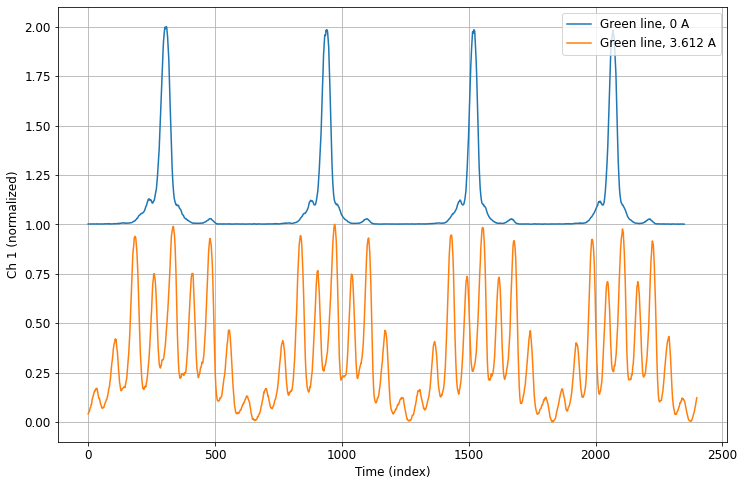

In [10]:
def normalize_array(ydata):
    normed_data = (ydata - ydata.min())/(ydata.max()-ydata.min())
    return normed_data

gr_0 = np.array(normalize_array(Green_B0['CH1'][250:2600]))
gr_B = np.array(normalize_array(Green_3612['CH1'][180:180+2400]))

plt.xlabel(r'Time (index)')
plt.ylabel(r'Ch 1 (normalized)')

plt.plot(1.0+gr_0,'-', label='Green line, 0 A')
plt.plot(gr_B,'-', label='Green line, 3.612 A')
plt.legend() 
plt.grid(); 

In [11]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

def find_and_plot_peaks(ydata, title='Data', makeplot=True, min_width=50, min_dist=200, rel_prom=0.5, smoothing=2):
    smooth_data = gaussian_filter1d(ydata,smoothing)

    peaks, pk_props = find_peaks(smooth_data, width = min_width, distance=min_dist, height=ydata.max()*rel_prom)
    
    ix = 0
    print('Peak  Loc   Width   Height')
    for pk, prop in zip(peaks, pk_props['widths']):
        ix += 1
        print('{:3d}  {:4d} {:7.1f}  {:6.2f}'.format(ix, pk, prop, ydata[pk]))

    if makeplot:
        plt.grid()
        plt.title('Peak finding for '+title)
        plt.ylabel(r'Intensity (normalized)')
        plt.xlabel(r'Array index')
        plt.plot(ydata,'-',label='Data')
        plt.plot(peaks, ydata[peaks],'o', color='C1', label='Locations')
        plt.hlines(y=pk_props['width_heights'], xmin=peaks-pk_props['widths']/2, 
                   xmax=peaks+pk_props['widths']/2, color = 'C3', label='Widths')
        plt.legend();
    
    return peaks, pk_props['widths'], pk_props['peak_heights']

Peak  Loc   Width   Height
  1   307    42.2    0.99
  2   940    38.7    0.98
  3  1520    36.5    0.98
  4  2068    35.4    0.98


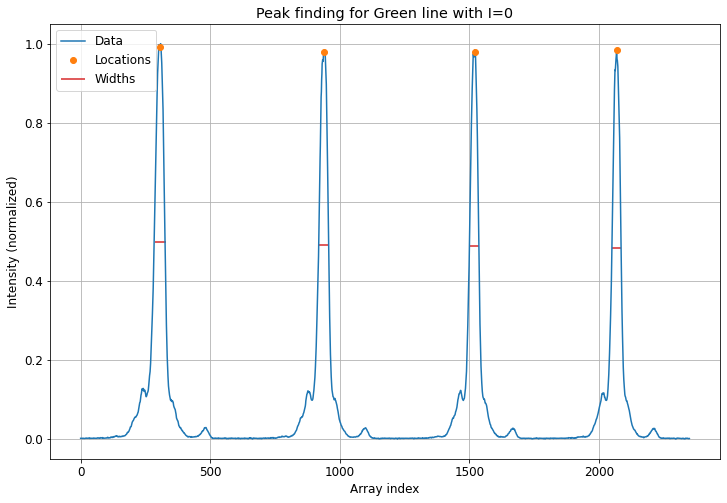

In [12]:
peaks,widths,heights = find_and_plot_peaks(gr_0,title='Green line with I=0', min_width = 10, min_dist = 50, rel_prom = 0.5, smoothing = 2)

In [13]:
from lmfit.models import LinearModel

line = LinearModel()

def model_fit_and_plot(xdata, ydata, model=LinearModel()):
    param_guess = model.guess(ydata, x = xdata)
    model_fit = model.fit(ydata, param_guess, x = xdata)

    model_fit.plot();
    return model_fit.params

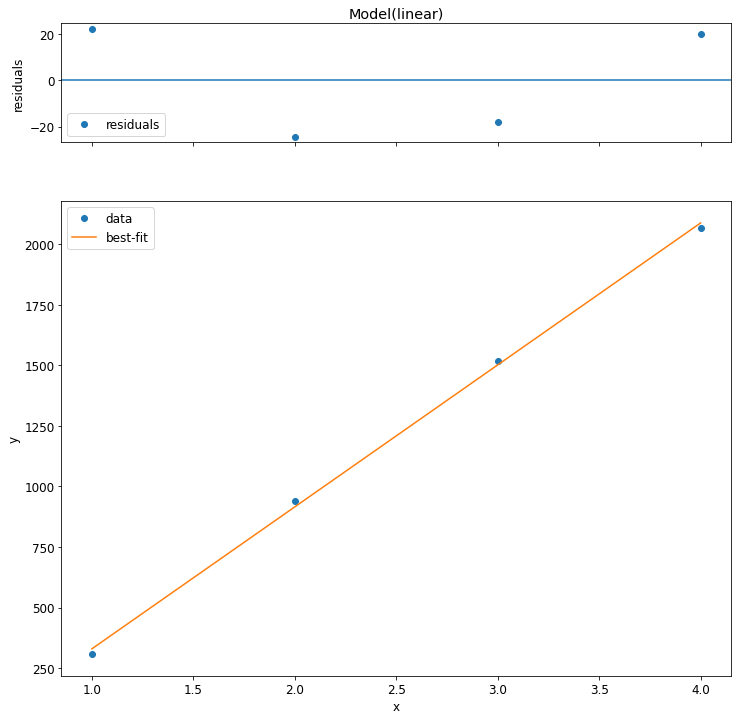

In [14]:
gr0_line = model_fit_and_plot([1,2,3,4], peaks)

In [15]:
separation = np.diff(peaks)
ave_separation = unc.ufloat(np.mean(separation),np.std(separation))
ave_width = unc.ufloat(np.mean(widths),np.std(widths))
print('\nEXERCISE 1: FROM ANALYSIS OF GREEN LINE WITH I=0')
print('Instrument finesse = {:.2uP}'.format(ave_separation/ave_width))


EXERCISE 1: FROM ANALYSIS OF GREEN LINE WITH I=0
Instrument finesse = 15.4±1.4


Peak  Loc   Width   Height
  1    32    26.0    0.17
  2   107    26.1    0.42
  3   185    33.7    0.94
  4   260    24.4    0.75
  5   335    39.9    0.99
  6   410    25.3    0.75
  7   481    29.0    0.93
  8   555    26.2    0.47
  9   626    28.1    0.13
 10   700    23.3    0.17
 11   767    24.7    0.41
 12   837    30.2    0.94
 13   904    22.6    0.76
 14   971    37.0    1.00
 15  1039    23.2    0.74
 16  1104    26.7    0.93
 17  1171    26.0    0.46
 18  1237    27.0    0.12
 19  1304    22.0    0.16
 20  1365    23.3    0.41
 21  1430    28.5    0.95
 22  1493    22.1    0.74
 23  1555    35.1    0.98
 24  1619    23.1    0.73
 25  1678    26.1    0.92
 26  1742    24.8    0.46
 27  1803    25.5    0.12
 28  1867    21.1    0.17
 29  1925    23.3    0.39
 30  1987    28.2    0.92
 31  2046    22.2    0.71
 32  2106    34.9    0.98
 33  2167    23.1    0.70
 34  2224    26.0    0.92
 35  2287    25.4    0.43
 36  2343    25.3    0.12


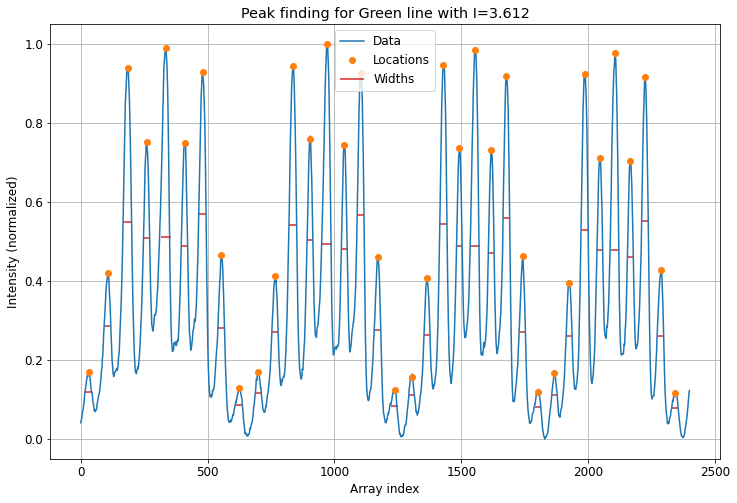

In [16]:
peaks,widths,heights = find_and_plot_peaks(gr_B, title='Green line with I=3.612', min_width = 5, min_dist = 50 , rel_prom = 0.1, smoothing = 3)

In [17]:
centrals = peaks[4::9]
print('Location of cetral peaks in each cluster: ',centrals)

Location of cetral peaks in each cluster:  [ 335  971 1555 2106]


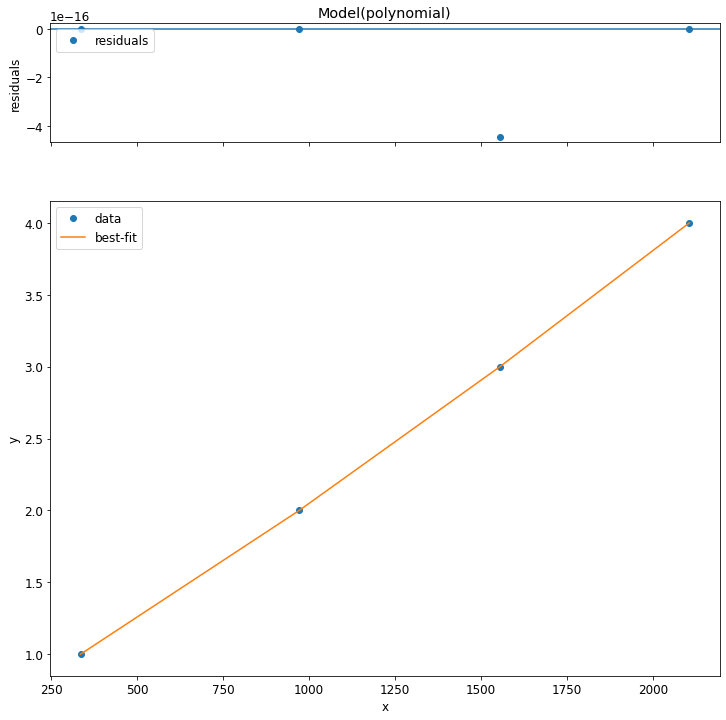

In [18]:
from lmfit.models import PolynomialModel

curve = PolynomialModel(degree=3)

green_curve = model_fit_and_plot(centrals, [1,2,3,4], model = curve)

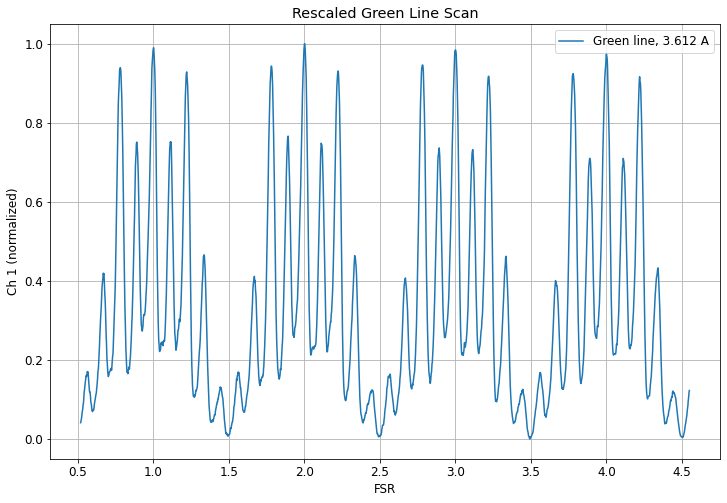

In [19]:
def green_cal(x,model=curve,params=green_curve):
    return model.eval(params, x=x)

index = list(range(2400))
x_0 = green_cal(index)

plt.title('Rescaled Green Line Scan')
plt.xlabel(r'FSR')
plt.ylabel(r'Ch 1 (normalized)')
plt.plot(x_0,gr_B,'-', label='Green line, 3.612 A')
plt.legend() 
plt.grid();

In [20]:
Green_scan_peaks = pd.DataFrame()
Green_scan_peaks['Peaks'] = green_cal(peaks)
Green_scan_peaks['Height'] = heights
green_FSR = Green_scan_peaks['Peaks']
Green_scan_peaks

,Peaks,Height
0,0.562205,0.164863
1,0.668045,0.408288
2,0.779906,0.926180
3,0.889146,0.731385
4,1.000000,0.974935
5,1.112432,0.736750
6,1.220292,0.907873
7,1.334149,0.451896
8,1.444741,0.126610
9,1.561383,0.163430


In [21]:
green_FSR[0]-green_FSR[4]
green_FSR[0::9]-green_FSR[4::9]
ave_shift_1 = np.mean(green_FSR[0::9]-green_FSR[4::9])
ave_shifts = np.zeros(9)
for i in range(0,9):
    ave_shifts[i] = np.mean(np.array(green_FSR[i::9])-np.array(green_FSR[4::9]))
ave_shifts

array([-0.43856403, -0.33257864, -0.21970664, -0.11034922,  0.        ,
        0.11306622,  0.22017403,  0.33517604,  0.44479967])

In [22]:
print(np.array(green_FSR[0::9])-green_FSR[4::9]) #test cell

4    -0.437795
13   -0.438617
22   -0.438270
31   -0.439574
Name: Peaks, dtype: float64


In [23]:
green_FSR[0::9]-green_FSR[4::9]

pG = np.zeros(9)
pG_std = np.zeros(9)

for i in range(0,9):
    pG[i] = np.mean(np.array(green_FSR[i::9])-np.array(green_FSR[4::9]))
    pG_std[i] = np.std(np.array(green_FSR[i::9])-np.array(green_FSR[4::9]))

Green_peaks = pd.DataFrame({'Shift (FSR)':up.uarray(pG,pG_std)},index=range(-4,5))
Green_peaks

,Shift (FSR)
-4,-0.4386+/-0.0007
-3,-0.3326+/-0.0007
-2,-0.2197+/-0.0004
-1,-0.1103+/-0.0007
0,0.0+/-0
1,0.1131+/-0.0005
2,0.2202+/-0.0009
3,0.3352+/-0.0017
4,0.4448+/-0.0013


In [24]:
Green_peaks['Shift (B*mu)'] = Green_peaks*conv_fact_green
Green_peaks['Theory (B*mu)'] = [-2.0,-1.5,-1.0,-0.5,0,0.5,1,1.5,2]
print('Averaged location of 546.07 nm peaks')
Green_peaks

Averaged location of 546.07 nm peaks


,Shift (FSR),Shift (B*mu),Theory (B*mu)
-4,-0.4386+/-0.0007,-1.961+/-0.004,-2.0
-3,-0.3326+/-0.0007,-1.487+/-0.004,-1.5
-2,-0.2197+/-0.0004,-0.9824+/-0.0024,-1.0
-1,-0.1103+/-0.0007,-0.4934+/-0.0032,-0.5
0,0.0+/-0,0.0+/-0,0.0
1,0.1131+/-0.0005,0.5056+/-0.0024,0.5
2,0.2202+/-0.0009,0.985+/-0.004,1.0
3,0.3352+/-0.0017,1.499+/-0.008,1.5
4,0.4448+/-0.0013,1.989+/-0.007,2.0


In [25]:
Yellow_B0 = pd.read_csv('Yellow_B0.csv', skiprows = 15)
Yellow_1817 = pd.read_csv('Yellow_1817A_no_polarizer.csv', skiprows = 15)

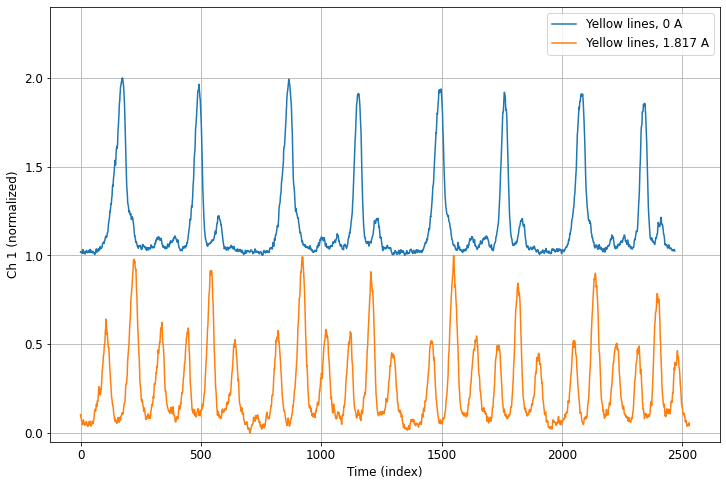

In [26]:
yel_0 = np.array(normalize_array(Yellow_B0['CH1'][130:2600]))
yel_B = np.array(normalize_array(Yellow_1817['CH1'][50:2580]))
                
plt.ylim(-0.05,2.4)
plt.xlabel(r'Time (index)')
plt.ylabel(r'Ch 1 (normalized)')
plt.plot(1.0+yel_0,'-', label='Yellow lines, 0 A')
plt.plot(yel_B,'-', label='Yellow lines, 1.817 A')
plt.legend() 
plt.grid(); 

Peak  Loc   Width   Height
  1   107    34.3    0.63
  2   223    40.5    0.98
  3   336    34.8    0.59
  4   445    26.5    0.56
  5   542    31.0    0.91
  6   641    28.1    0.52
  7   820    32.3    0.58
  8   922    36.6    0.99
  9  1021    32.7    0.58
 10  1121    27.3    0.57
 11  1207    30.7    0.89
 12  1295    31.8    0.44
 13  1458    32.1    0.51
 14  1550    36.5    1.00
 15  1644    33.6    0.52
 16  1736    29.4    0.47
 17  1818    31.1    0.83
 18  1903    30.3    0.45
 19  2050    31.5    0.48
 20  2138    36.0    0.88
 21  2226    33.0    0.49
 22  2318    28.2    0.46
 23  2398    31.2    0.77
 24  2480    29.7    0.46


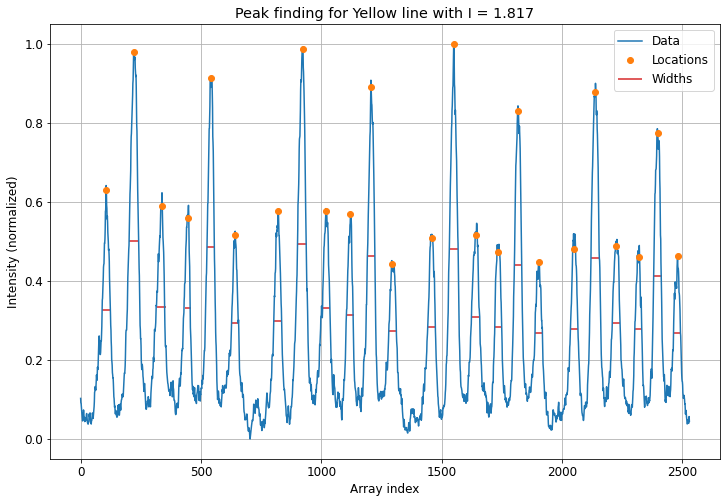

In [27]:
peaks,widths,heights = find_and_plot_peaks(yel_B,title='Yellow line with I = 1.817', min_width = 10, min_dist = 40, rel_prom = 0.3, smoothing = 3)

In [28]:
idx577 = np.array([0,1,2,6,7,8,12,13,14,18,19,20], dtype=int)
idx579 = idx577 + 3

peaks577 = peaks[idx577]
peaks579 = peaks[idx579]

print('577 nm peaks at ',peaks577)
print('579 nm peaks at ',peaks579)

577 nm peaks at  [ 107  223  336  820  922 1021 1458 1550 1644 2050 2138 2226]
579 nm peaks at  [ 445  542  641 1121 1207 1295 1736 1818 1903 2318 2398 2480]


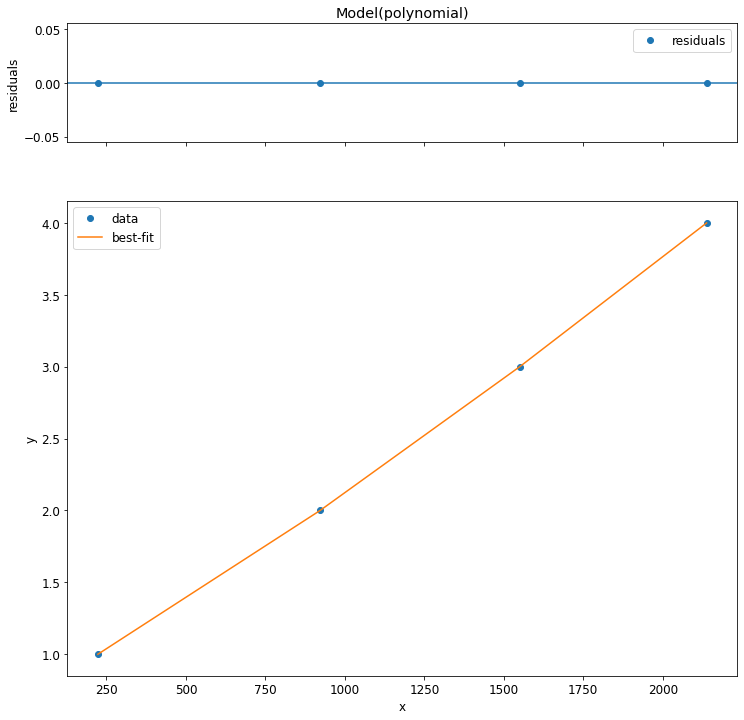

In [29]:
centrals577 = [223,922,1550,2138]

yel577_curve = model_fit_and_plot(centrals577, [1,2,3,4],model=curve)

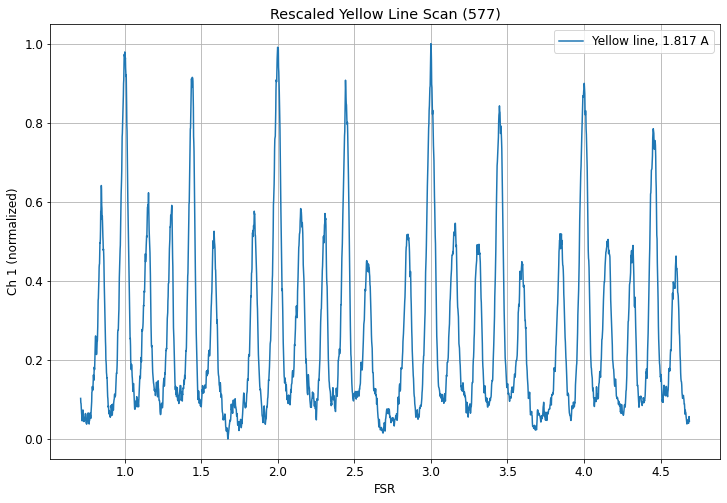

In [30]:
def yel577_cal(x,model=curve,params=yel577_curve):
        return model.eval(params, x=x)
    
x_yel = yel577_cal(list(range(2530)))

plt.title('Rescaled Yellow Line Scan (577)')
plt.xlabel(r'FSR')
plt.ylabel(r'Ch 1 (normalized)')
plt.plot(x_yel,yel_B,'-', label='Yellow line, 1.817 A')
plt.legend() 
plt.grid();

In [31]:
Yellow577_scan_peaks = pd.DataFrame()
Yellow577_scan_peaks['Peaks'] = yel577_cal(peaks)
Yellow577_scan_peaks['Height'] = heights

yellow_FSR = Yellow577_scan_peaks['Peaks']

print('Locations of 577 nm peaks:')
Yellow577_scan_peaks

Locations of 577 nm peaks:


,Peaks,Height
0,0.847909,0.587715
1,1.000000,0.957892
2,1.152212,0.581011
3,1.302685,0.557460
4,1.439498,0.897419
5,1.581852,0.498052
6,1.845894,0.545297
7,2.000000,0.962294
8,2.151976,0.561734
9,2.307787,0.538797


In [32]:
y577 = np.zeros(3)
y577_std = np.zeros(3)

for i in range(0,3):
    y577[i] = np.mean(np.array(yellow_FSR[i::6])-np.array(yellow_FSR[1::6]))
    y577_std[i] = np.std(np.array(yellow_FSR[i::6])-np.array(yellow_FSR[1::6]))

Yellow577_peaks = pd.DataFrame({'Shift (FSR)':up.uarray(y577,y577_std)},index=range(-1,2))

Yellow577_peaks['Energy (B*mu)']=conv_fact_yellow*Yellow577_peaks

Yellow577_peaks['Theory (B*mu)']= [-7/6,0,7/6]

print('Averaged locations of 577 nm peaks:')
Yellow577_peaks

Averaged locations of 577 nm peaks:


,Shift (FSR),Energy (B*mu),Theory (B*mu)
-1,-0.1526+/-0.0010,-1.219+/-0.009,-1.166667
0,0.0+/-0,0.0+/-0,0.000000
1,0.1535+/-0.0017,1.226+/-0.014,1.166667


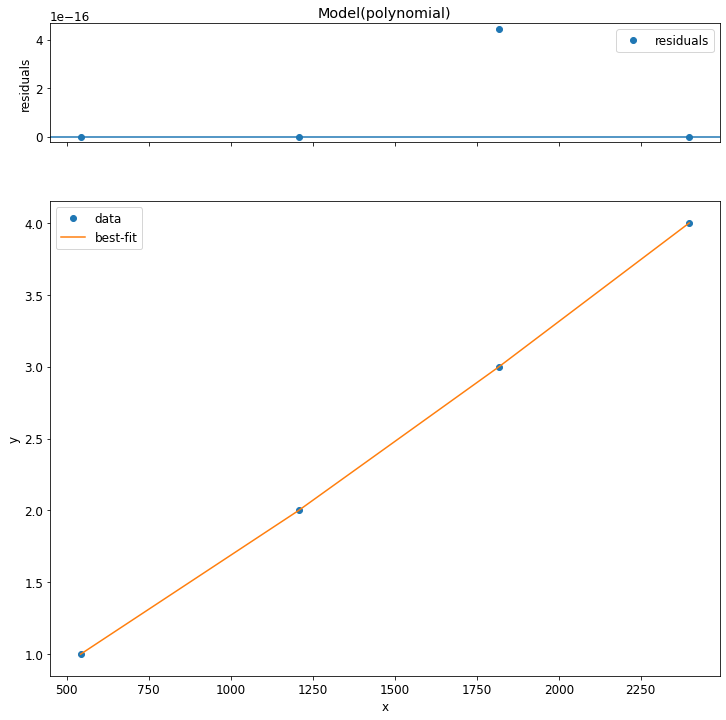

In [33]:
centrals579 = [542,1207,1818,2398]

yel579_curve = model_fit_and_plot(centrals579, [1,2,3,4],model=curve)

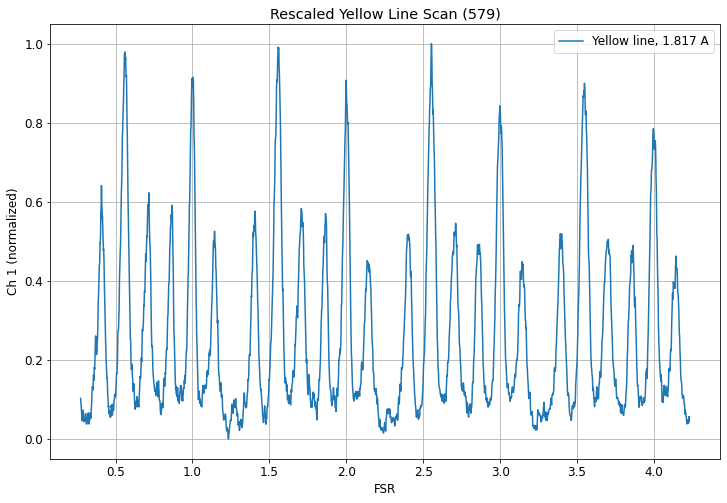

In [34]:
def yel579_cal(x,model=curve,params=yel579_curve):
    return model.eval(params, x=x)
        
x_yel = yel579_cal(list(range(2530)))

plt.title('Rescaled Yellow Line Scan (579)')
plt.xlabel(r'FSR')
plt.ylabel(r'Ch 1 (normalized)')
plt.plot(x_yel,yel_B,'-', label='Yellow line, 1.817 A')
plt.legend() 
plt.grid();

In [35]:
Yellow579_scan_peaks = pd.DataFrame()
Yellow579_scan_peaks['Peaks'] = yel579_cal(peaks)
Yellow579_scan_peaks['Height'] = heights

yellow_FSR = Yellow579_scan_peaks['Peaks']

print('Locations of 579 nm peaks:')
Yellow579_scan_peaks

Locations of 579 nm peaks:


,Peaks,Height
0,0.409248,0.587715
1,0.561278,0.957892
2,0.713313,0.581011
3,0.863513,0.557460
4,1.000000,0.897419
5,1.141945,0.498052
6,1.405063,0.545297
7,1.558543,0.962294
8,1.709846,0.561734
9,1.864916,0.538797


In [36]:
y579 = np.zeros(3)
y579_std = np.zeros(3)

for i in range(0,3):
    y579[i] = np.mean(np.array(yellow_FSR[i::6])-np.array(yellow_FSR[1::6]))
    y579_std[i] = np.std(np.array(yellow_FSR[i::6])-np.array(yellow_FSR[1::6]))

Yellow579_peaks = pd.DataFrame({'Shift (FSR)':up.uarray(y579,y579_std)},index=range(-1,2))

Yellow579_peaks['Energy (B*mu)']=conv_fact_yellow*Yellow579_peaks

Yellow579_peaks['Theory (B*mu)']= [-1,0,1]

print('Averaged locations of 579 nm peaks:')
Yellow579_peaks

Averaged locations of 579 nm peaks:


,Shift (FSR),Energy (B*mu),Theory (B*mu)
-1,-0.1519+/-0.0010,-1.214+/-0.009,-1
0,0.0+/-0,0.0+/-0,0
1,0.1528+/-0.0015,1.221+/-0.013,1


In [37]:
def g(L,S,J):
    g = 1 + (J*(J+1) + S*(S+1) - L*(L+1))/(2*J*(J+1))
    return g

In [38]:
g_values = pd.DataFrame() #S L=0   P L=1    D L=2    F L=3
g_values['State Name'] = ['(7s)3S1','(6p)3P2','(6d)3D2','(6p)1P1','(6d)1D2','(6p)1P1']
g_values['L'] = [0,1,2,1,2,1]
g_values['S'] = [1,1,1,0,0,0]
g_values['J'] = [1,2,2,1,2,1]
g_values['g'] = g(g_values['L'],g_values['S'],g_values['J'])
g_values

,State Name,L,S,J,g
0,(7s)3S1,0,1,1,2.000000
1,(6p)3P2,1,1,2,1.500000
2,(6d)3D2,2,1,2,1.166667
3,(6p)1P1,1,0,1,1.000000
4,(6d)1D2,2,0,2,1.000000
5,(6p)1P1,1,0,1,1.000000


In [39]:
def coe(gi,gf,mi,mf):
    E = (gi*mi - gf*mf)
    return E

In [40]:
theory = pd.DataFrame()
theory['546.07 Green Line'] = [coe(2,1.5,-1,0),coe(2,1.5,0,1),coe(2,1.5,1,2),coe(2,1.5,-1,-1),coe(2,1.5,0,0),coe(2,1.5,1,1),coe(2,1.5,-1,-2),coe(2,1.5,0,-1),coe(2,1.5,1,0)]
theory['576.96 Yellow Line'] = [coe(7/6,1,-2,-1),coe(7/6,1,-1,0),coe(7/6,1,0,1),coe(7/6,1,-1,-1),coe(7/6,1,0,0),coe(7/6,1,1,1),coe(7/6,1,0,-1),coe(7/6,1,1,0),coe(7/6,1,2,1)]
theory['579.07 Yellow Line'] = [coe(1,1,-2,-1),coe(1,1,-1,0),coe(1,1,0,1),coe(1,1,-1,-1),coe(1,1,0,0),coe(1,1,1,1),coe(1,1,0,-1),coe(1,1,1,0),coe(1,1,2,1)]
theory

,546.07 Green Line,576.96 Yellow Line,579.07 Yellow Line
0,-2.0,-1.333333,-1
1,-1.5,-1.166667,-1
2,-1.0,-1.000000,-1
3,-0.5,-0.166667,0
4,0.0,0.000000,0
5,0.5,0.166667,0
6,1.0,1.000000,1
7,1.5,1.166667,1
8,2.0,1.333333,1
